In [1]:
import os
from matplotlib import pyplot as plt
import numpy as np

In [2]:
dir = '../metric/group_user_var2_ph_seed0/groundtruth/1.0_0_1000_1_50/ciao100.10.20.70.250.251.010.00.5/'

methods = os.listdir(dir)
print('methods', methods)
all_records = dict([(k, []) for k in methods])
valid_records = dict([(k, []) for k in methods])
all_policy = dict([(k, []) for k in methods])
valid_policy = dict([(k, []) for k in methods])

for method in methods:
    user_item_records = sorted(os.listdir(os.path.join(dir, method)))
    
    for user_item_record in user_item_records:
        if 'metric' in user_item_record:
            valid_records[method].append(user_item_record)
            file_dir = os.path.join(dir, method, user_item_record)
            
            with open(file_dir, 'r') as f:
                lines = f.readlines()
                lines = [line.split() for line in lines]
                lines = [[float(x) for x in line] for line in lines]
                lines = np.array(lines)
                all_records[method].append(lines[:, [2, 5]])
        else:
            valid_policy[method].append(user_item_record)
            file_dir = os.path.join(dir, method, user_item_record)
            with open(file_dir, 'r') as f:
                lines = f.readlines()
                lines = [line.split() for line in lines]
                lines = [[float(x) for x in line] for line in lines]
                lines = np.array(lines)
                all_policy[method].append(lines)
        



methods ['spill_groundtruth', 'spill_simulation_mf', 'spill_diffnet', 'spill_simulation_diffnet', 'spill_mf', 'spill_gatv2_spill_var2']


In [3]:
min_loss = 0.
for method in methods:
    for x in all_records[method]:
        min_loss = min(min_loss, np.min(x[:, 1]))

In [4]:
loss_diff = 0.01
losses = np.arange(min_loss, 0, loss_diff)

In [5]:
num_user_item_pair = len(all_records[methods[0]])
uplift_all = dict([(k, []) for k in methods])

for i in range(num_user_item_pair):
    for method in methods:
        record_idx = 0
        uplift, min_loss = all_records[method][i][0]
        uplifts = np.zeros(len(losses))
        for j in range(len(losses)):
            if record_idx == 0:
                if losses[j] <= min_loss:
                    uplifts[j] = uplift
                else:
                    while losses[j] > all_records[method][i][record_idx][1]:
                        record_idx += 1
                    uplift_left = uplift
                    uplift, min_loss = all_records[method][i][record_idx]
                    uplifts[j] = uplift_left
            else:
                if losses[j] <= min_loss:
                    uplifts[j] = uplift_left
                else:
                    while losses[j] > all_records[method][i][record_idx][1]:
                        record_idx += 1
                    uplift_left = uplift
                    uplift, min_loss = all_records[method][i][record_idx]
                    uplifts[j] = uplift_left
        uplifts[-1], _ = all_records[method][i][-1]
        uplift_all[method].append(uplifts)


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


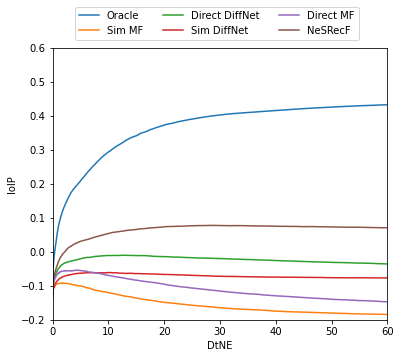

In [6]:
# set font 
plt.rcParams["font.family"] = "Times New Roman"
model_name={'spill_groundtruth':'Oracle', 'spill_simulation_mf':'Sim MF', 'spill_simulation_diffnet':'Sim DiffNet', 'spill_mf':'Direct MF', 'spill_diffnet':'Direct DiffNet', 'spill_gatv2_spill_var2':'NeSRecF'}
plt.figure(figsize=(6, 5))
for method in methods:
    # if method == 'groundtruth':
    #     continue
    plt.plot(-losses, np.mean(uplift_all[method], axis=0), label=model_name[method])
plt.xlabel('DtNE')
plt.ylabel('IoIP')
# set x range
plt.xlim(0, 60)
plt.ylim(-0.2, 0.6)
# set the position of the legend
plt.legend(loc='upper right', bbox_to_anchor=(0.93, 1.17), ncol=3)
